<a href="https://colab.research.google.com/github/gabrielgranados97/Tarea_5_PLN/blob/main/Tarea5_LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Gabriel Fernando Granados Álvarez**

**Universidad Nacional de Colombia**

**Lenguaje Natural**

Tarea n°5

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np 

from tensorflow.keras.utils import plot_model

In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Lectura de datos**

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2022-06-04 20:39:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.198.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.002s  

2022-06-04 20:39:22 (51.7 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



**Tokeniza el texto**

In [ ]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

#print('Dictionary: ',tokenizer.word_index,'\n')
print('índice de rage = ',tokenizer.word_index['rage'])
print('\nTNúmero total d palabras en el Tokenizador (+OOV) =',total_words,'\n')

# Muestra parte del corpus
print('Primeras líneas del corpus: \n')
corpus[0:10]

índice de rage =  443

TNúmero total d palabras en el Tokenizador (+OOV) = 3211 

Primeras líneas del corpus: 



['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

**Crea n-Grams para datos de entrenamiento y etiquetas**

In [ ]:
# crear secuencias de entrada usando una lista de tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
print('input_sequences[0:10] = ',input_sequences[:10],'\n')

# Determine el n-gram más largo
max_seq_test_len = max([len(x) for x in input_sequences])
print('\nlongitud del  n-grama más largo:',max_seq_test_len)

input_sequences[0:10] =  [[34, 417], [34, 417, 877], [34, 417, 877, 166], [34, 417, 877, 166, 213], [34, 417, 877, 166, 213, 517], [8, 878], [8, 878, 134], [8, 878, 134, 351], [8, 878, 134, 351, 102], [8, 878, 134, 351, 102, 156]] 


longitud del  n-grama más largo: 11


**Agrega PAD para tener secuencias de la misma longitud**

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# crea predictores y etiqueta
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

In [ ]:
print(input_sequences.shape)
print(predictors.shape)
print(label.shape)

(15462, 11)
(15462, 10)
(15462,)


In [ ]:
print(input_sequences[0:3]) # secuencia completa
print('\n')
print(predictors[0:3]) # secuencia hasta el anterior al último
print('\n')
print(label[0:3]) # el último de la secuencia

[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]]


[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]]


[417 877 166]


**Covierte etiquetas a 1-hot**

In [ ]:
label = to_categorical(label, num_classes=total_words)
print(label.shape)

(15462, 3211)


**Enmascaramiento**

In [ ]:
class PaddingMask(tf.keras.layers.Layer):
    def __init__(self, seq):
        super(PaddingMask, self).__init__()
        self.mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # adiciona dimensiones extra para adicionar el relleno
        # a los logits de atención
        self.mask = self.mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
    
    def call():
        return self.mask

**Modelo**

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1605)              162105    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                        

**Entrenamiento**

In [ ]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 71s 135ms/step - loss: 6.9031 - accuracy: 0.0205
Epoch 2/100
484/484 [==============================] - 56s 116ms/step - loss: 6.5024 - accuracy: 0.0209
Epoch 3/100
484/484 [==============================] - 55s 114ms/step - loss: 6.3647 - accuracy: 0.0262
Epoch 4/100
484/484 [==============================] - 55s 113ms/step - loss: 6.2496 - accuracy: 0.0305
Epoch 5/100
484/484 [==============================] - 55s 114ms/step - loss: 6.1744 - accuracy: 0.0351
Epoch 6/100
484/484 [==============================] - 55s 114ms/step - loss: 6.1017 - accuracy: 0.0380
Epoch 7/100
484/484 [==============================] - 55s 113ms/step - loss: 6.0247 - accuracy: 0.0407
Epoch 8/100
484/484 [==============================] - 55s 114ms/step - loss: 5.9479 - accuracy: 0.0444
Epoch 9/100
484/484 [==============================] - 55s 114ms/step - loss: 5.8506 - accuracy: 0.0514
Epoch 10/100
484/484 [==============================] - 55s 114m

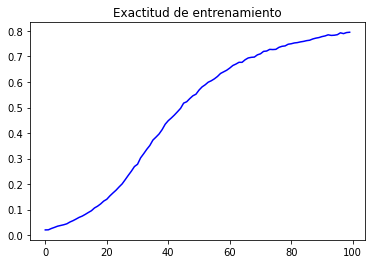

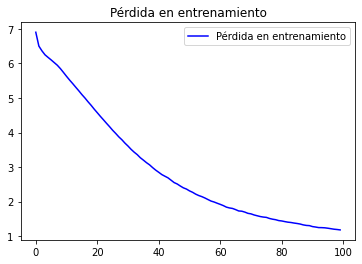

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Exactitud de entrenamiento')
plt.title('Exactitud de entrenamiento')

plt.figure()

plt.plot(epochs, loss, 'b', label='Pérdida en entrenamiento')
plt.title('Pérdida en entrenamiento')
plt.legend()

plt.show()

**Generación de texto automático**

In [ ]:
seed_text = "Who are you?"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

AttributeError: ignored